In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset
For this tutorial, we will use a IMDb dataset with plots and associated genres. We define our task as classifying the plots as those of action or romance movies based only on the plot text. 

To download the dataset, run `wget blah blah` from the `data/` folder. This will create a `imdb` folder with `imdb_plots.tsv` and `budgetandactors.txt`. We pre-process the data below to generate the following:
* Featurize the plot text using bag-of-words representation
* Split the dataset into train, val, and test

**TODO: Featurize in loader and load in the words each feature represents**

In [6]:
dataset='imdb'

from data.loader import DataLoader
dl = DataLoader()
train_primitive_matrix, val_primitive_matrix, test_primitive_matrix, \
train_ground, val_ground, test_ground, _, _, _ = dl.load_data(dataset=dataset)

# Reef Steps
We go through the three stages of Reef individually and then repeat the process iteratively. We run a single iteration in the cell below and look at the individual steps in more detail in Steps 1-3.

In [ ]:
from program_synthesis.heuristic_generator import HeuristicGenerator

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, val_ground, train_ground, b=0.5)
hg.run_synthesizer(max_cardinality=1, idx=None, keep=3, model='dt')

## 1. Synthesize Heuristics
We start by generating all possible heuristics based on the labeled, validation set that take in a single feature (i.e. word for this example) as input. 

For this example, we use decision trees with maximum depth 1 (`dt`) as our heuristic form. As we will see later, this translates to checking whether a certain word exists or does not exist in the text to assign a label. We first generate all possible heuristics that take a single feature in as input.

In [ ]:
from program_synthesis.synthesizer import Synthesizer
syn = Synthesizer(val_primitive_matrix, val_ground, b=0.5)

heuristics, feature_inputs = syn.generate_heuristics('nn', 1)
print "Total Heuristics Generated: ", np.shape(heuristics)[1]

For each heuristics, we then find the $\beta$ value associated with each heuristic that decides when to abstain based its F1 score on the labeled validation set.

In [3]:
optimal_betas = syn.find_optimal_beta(heuristics[0], val_primitive_matrix, feature_inputs[0], val_ground)
plt.hist(optimal_betas, range=(0,0.5));
plt.xlabel('Beta Values');

NameError: name 'syn' is not defined

## 2. Prune Heuristics
In the first iteration, we simply pick the 3 heuristics that perform the best on the labeled validation set. 

In [10]:
top_idx = hg.prune_heuristics(heuristics, feature_inputs, keep=3)
print 'Features chosen heuristics are based on: ', top_idx

Features chosen heuristics are based on:  [237 168 232]


In subsequent iterations (step 4), we weight the Jaccard score (overlap of how many datapoints in the train set receive labels and how many are labeled by existing heuristics) and F1 score equally. We demonstrate this with a toy vector of previously labeled data.

## 3. Verify Heuristics
In this step, we use the labels the heuristics assign to the __unlabeled train set__ to estimate heuristic accuracies and assign probabilistic training labels to the same set accordingly (see [snorkel.stanford.edu](http://snorkel.stanford.edu) for more details). 

In [11]:
from program_synthesis.verifier import Verifier
verifier = Verifier(hg.L_train, hg.L_val, val_ground, has_snorkel=False)

verifier.train_gen_model()
verifier.assign_marginals()

We visualize what these labels look like. Note that with a single iterations, none of the datapoints receive a probabilistic label greater than 0.5, but this is fixed after running the process iteratively (Step 4). __These labels are then used to train an end model, such as an LSTM, and not used as final predictions.__ 

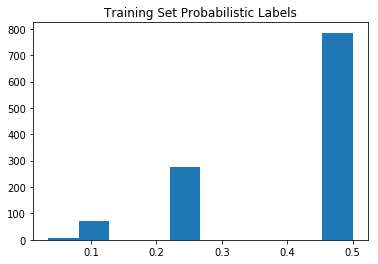

In [12]:
plt.hist(verifier.train_marginals); plt.title('Training Set Probabilistic Labels');

Since we do not have access to ground truth labels for the train set, we use the distribution of labels for the labeled validation set to decide what feedback to pass to the synthesizer. We pass datapoints with low confidence (labels near 0.5, i.e. equal probability of being +1 or -1) to the synthesizer

Percentage of Low Confidence Points:  0.735915492958


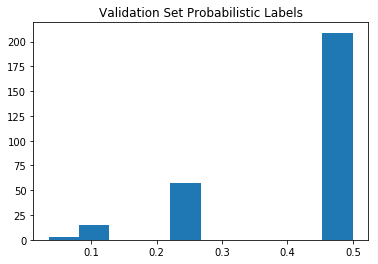

In [13]:
plt.hist(verifier.val_marginals); plt.title('Validation Set Probabilistic Labels');
feedback_idx = verifier.find_vague_points(gamma=0.1,b=0.5)
print 'Percentage of Low Confidence Points: ', np.shape(feedback_idx)[0]/float(np.shape(val_ground)[0])

## 4. Repeat Iterative Process of Generating Heuristics
We repeat this process of synthesizing, pruning, and verifying heuristics iteratively. In this example, we generate 25 total heuristics. 

In [14]:
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []

training_marginals = []
idx = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=0.5)
for i in range(3,26):
    #Repeat synthesize-prune-verify at each iterations
    if i == 3:
        hg.run_synthesizer(max_cardinality=1, idx=idx, keep=3, model='dt')
    else:
        hg.run_synthesizer(max_cardinality=1, idx=idx, keep=1, model='dt')
    hg.run_verifier()
    
    #Save evaluation metrics
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    training_marginals.append(hg.vf.train_marginals)
    validation_coverage.append(vc)
    training_coverage.append(tc)
    
    #Plot Training Set Label Distribution
    if (i-2)%5 == 0:
        plt.figure();
        plt.hist(training_marginals[-1]); plt.title('Iteration ' + str(i-2));
    
    #Find low confidence datapoints in the labeled set
    hg.find_feedback()
    idx = hg.feedback_idx
    
    #Stop the iterative process when no low confidence labels
    if idx == []:
        break

TypeError: list indices must be integers, not list

We look at the accuracy of the training set labels (because in this case, we have access to the ground truth labels for the train set). The coverage is the percentage of training set datapoints that receive at least one label from the generated heuristics.

In [ ]:
print "Program Synthesis Train Accuracy: ", training_accuracy[-1]
print "Program Synthesis Train Coverage: ", training_coverage[-1]
print "Program Synthesis Validation Accuracy: ", validation_accuracy[-1]

### Save Training Set Labels 
We save the training set labels Reef generates and the ground truth labels that we use in the next notebook to train a simple LSTM model.

In [ ]:
filepath = './data/' + dataset
np.save(filepath+'_reef.npy', training_marginals[-1])
np.save(filepath+'_ground.npy', train_ground)